# Automated Tracking of monomers in a chain

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob, os
from rayleighsommerfeld02 import rayleighsommerfeld
from numpy import diff
import pandas as pd
from findpeaks import findpeaks
import pprint
import trackpy as tp

In [1]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg

app = QApplication.instance() or QApplication([])

### pull up the first image from this experiment

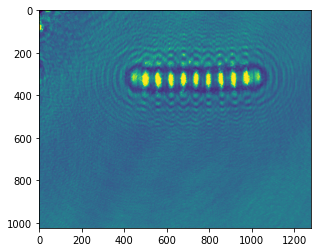

In [3]:
fg = plt.imread('./060922/norm_images_10-mer_600' + '/image0000.png')
plt.imshow(fg)

### crop feature to a 512x512 image

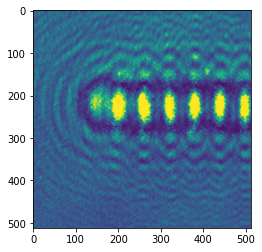

In [4]:
xmin = 300 
ymin = 100
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]
plt.imshow(fg_cropped)

### run rayleigh-sommerfeld algorithm 

In [7]:
zmin = -20 #in um
zmax = 0 
n = 400
mpp = 0.048

z = np.linspace(zmin, zmax, n) / mpp #in px

last_z_list = [z for i in range(6)]
b = fg_cropped
rs = rayleighsommerfeld(b, z, magnification=mpp, nozphase=True)
bz = np.abs(rs).astype(float)
phi = np.angle(rs - 1.)

In [8]:
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

### pull up image at focus to get $x_1^{(1)}, y_1^{(1)}, x_1^{(2)}, y_1^{(2)},$ etc (chosen manually)
### Tracking only one monomer

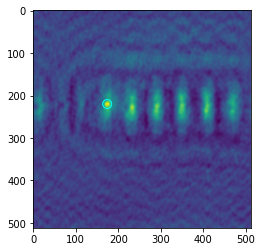

In [10]:
z_guess = 40

fig, ax = plt.subplots()
ax.imshow(bz[:,:,z_guess])

zlist = []
xlist = [174]
ylist = [220]

for i in range(len(xlist)):
    ax.scatter(xlist[i],ylist[i],s=80, facecolors='none', edgecolors='cyan')
plt.show()

### get $z_p$ predictions for first frame

guess from intensity -18.650
z_p =  -18.9 with L_0 = 22


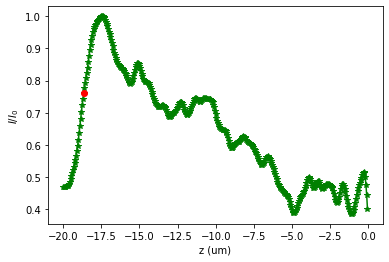

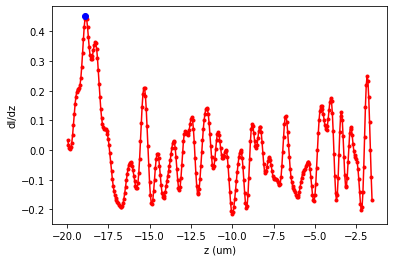

In [11]:
#particle n
m_index = 0

Y = []
z = []

n = 400
for i in np.linspace(0, n-1, n):
    i = int(i)
    z.append((zmin + i/n * (zmax - zmin))) #in um
    Y.append(bz[ylist[m_index],xlist[m_index],i])

Y = [y/np.max(Y) for y in Y]    
plt.ylabel(r'$I/I_0$')
plt.xlabel('z (um)')
plt.plot(z,Y,'g*-')

max_Y = np.max(Y)
thresh = 0.25 #within 30% of max values
indexes = [count for count, el in enumerate(Y) if (max_Y-el)/max_Y < thresh]
z_f = z[indexes[0]]
print('guess from intensity', format(z_f, ".3f")) #in um

_=plt.plot(z_f, Y[indexes[0]], 'ro')

#############################################################################
fig, ax = plt.subplots()

dx = 1*(zmax - zmin) / n #in um
dy = diff(Y)/dx #Y is the intensity
dy = dy[:len(dy)-30] #avoid potential z=0 singularity

sorted_dy = dy.copy()
sorted_dy.sort()
max_val = sorted_dy[-1]#change to -1 if no singularity at center

L = [i for i in range(len(dy)) if dy[i]==max_val] 
print('z_p = ', z[L[0]], 'with L_0 = {}'.format(L[0]))
plt.ylabel('dI/dz')
plt.xlabel('z (um)')

plt.plot(z[1:len(z)-30],dy, 'r.-')
plt.plot(z[L[0]],dy[L[0]], 'bo')

In [ ]:
zlist = []
zlist.append(z[L[0]])
print(zlist)

### save to dictionary

In [ ]:
save_data = {}
framenum = 0
x = xlist[m_index]*mpp
y = ylist[m_index]*mpp
z = -zlist[0]
save_data[framenum] = (x,y,z)
print(save_data)

### <font color='green'>Helper Function:</font> find index of closest coordinates for query  (xq, yq)

In [4]:
def get_closest_coords(xq, yq, xlist, ylist):
    dist = [(xlist[i]-xq)**2 + (ylist[i]-yq)**2 for i in range(len(xlist))]
    min_index = dist.index(min(dist))
    return min_index

In [5]:
values_to_be_interpolated = []
save_data = np.load('monomer060922_10-mer600_0.npy', allow_pickle = True).item()

### now that we have initial guesses, let's try to automate the process (the whole point of all of this)

./060922/norm_images_10-mer_600/image0700.png
max gradient at: 313.7844611528822, corresponding z index at: 329
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 60.
[findpeaks] >Detect peaks using topology method with limit at 60.
[findpeaks] >Fin.


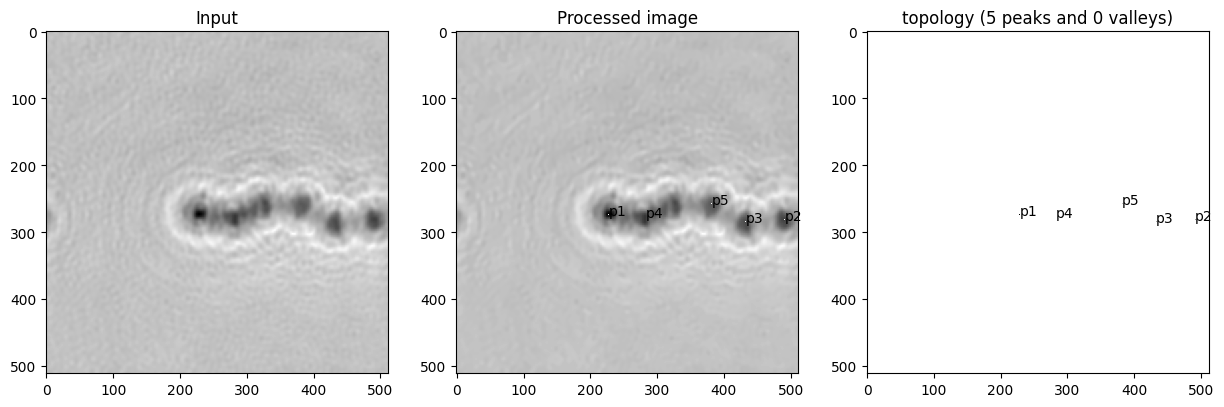

x guess: 227.0 x fit: 228 
 y_guess: 271.0 y_fit: 274 
 index: p1 
 delta: 3.1622776601683795
[10.944] [13.152000000000001] [4.260651629072683]
[]
time elapsed = 58.08446907997131


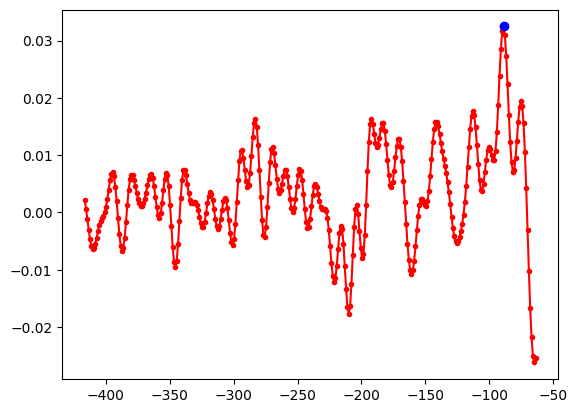

In [126]:
import time

start = time.time() #time it

framenum = 700

current_x_list = []
current_y_list = []
current_z_list = []

#get image and crop
t = str(framenum).zfill(4)
filename = './060922/norm_images_10-mer_600' + '/image{}.png'.format(t)
print(filename)
fg = plt.imread(filename)
xmin = 300
ymin = 100
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]
        
#get initial x,y guesses in units of pixels on a 512x512 grid. convert z later
x0 = save_data[framenum-20][0]/0.048
y0 = save_data[framenum-20][1]/0.048
z0 = save_data[framenum-20][2]

#z is the range for rs. It is in pixels. Find the appropriate z index corresponding to the guess z0
mpp = 0.048
zmin = -20 #in um
zmax = 0 
z = np.linspace(zmin, zmax, 400) / mpp #in px

rs = rayleighsommerfeld(fg_cropped, z, magnification=mpp, nozphase=True)
bz = np.abs(rs).astype(float)

full_range = (max(z) - min(z)) #in px
z0/=-mpp #make our guess for z negative and in px
z_max_grad = ((z0-min(z))/full_range)*len(z)

#the gradient of intensity is maximized near but not at the focus. There is a relationship between 
    #where the focus is and where the gradient is maximized. 
z_index = round((z_max_grad + 16.6)/1.02)+5#start a little after last frame
print('max gradient at: {},'.format(z_max_grad), 'corresponding z index at: {}'.format(z_index))

#completely changed this bit. delta is the difference between y_guess and y_fit, x_guess and x_fit. If the difference is too large
    #then run the algorithm again for a different z_guess by increasing z_guess (since it is possible that it is stuck at a prior value)
delta = 40
while delta > 19:
    print("delta is...{}".format(delta))
    #now select the frame that corresponds to our guess for z from last frame
    b = bz[:,:,round(z_index)]
    #peakfinding:
    thresh = 60
    win = 2 
    fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=win, togray=True, limit = thresh)
    results = fp.fit(b)
    fp.plot()
    x_fit = results['persistence'].x
    y_fit = results['persistence'].y

    #choose features that are closest to our guess
    index = get_closest_coords(x0, y0, x_fit, y_fit)
    x = x_fit[index]
    y = y_fit[index]

    #delta = abs(y0-y)+abs(x0-x)
    delta = np.sqrt(np.abs((y0-y)**2 + abs(x0-x)**2))
    z_index+=5 #move closer and closer to zero

print('x guess: {}'.format(x0), 'x fit: {}'.format(x), '\n', 'y_guess: {}'.format(y0), 'y_fit: {}'.format(y), '\n', 'index: p{}'.format(index+1), '\n', 'delta: {}'.format(delta))

#we have a guess for z0. Run rayleigh sommerfeld for a smaller range of z, centered around this guess
z = np.linspace(zmin, zmax, 400) / mpp #in px
rs = rayleighsommerfeld(fg_cropped, z, magnification=mpp, nozphase=True)
bz = np.abs(rs).astype(float)

#time to find z
#since we have exact x and y values, look at intensity list at that location across different z's
intensity_list = bz[y,x,:]
dx = 1
dy = diff(intensity_list)/dx
dy = dy[:z_index+5] #in case there is singularly large value at z=0
#choose z value for which gradient of intensity dI/dz is maximized, ignoring points close to 0.
sorted_dy = dy.copy()
sorted_dy.sort()
max_val = sorted_dy[-1]
L = [i for i in range(len(dy)) if dy[i]==max_val] 
zf = z[L[0]]

plt.plot(z[:z_index+5],dy, 'r.-')
plt.plot(z[L[0]],dy[L[0]], 'bo')

#save and check if z needs to be interpolated for later
current_x_list.append(x*0.048)
current_y_list.append(y*0.048)
current_z_list.append(-zf*0.048)
        
#print all results
print(current_x_list, current_y_list, current_z_list)
print(values_to_be_interpolated)

end = time.time()
print('time elapsed = {}'.format(end - start))

In [127]:
x = current_x_list[0]
y = current_y_list[0]
z = current_z_list[0]
save_data[framenum] = (x,y,z)
np.save('monomer060922_10-mer600_0.npy', save_data)
print(save_data)

{0: (8.352, 10.56, 18.9), 20: (8.256, 10.608, 18.796992481203006), 40: (8.256, 10.608, 18.847117794486216), 60: (8.304, 10.608, 18.24561403508772), 80: (8.4, 10.656, 18.546365914786968), 100: (8.304, 10.56, 18.847117794486216), 120: (8.736, 10.416, 17.694235588972433), 140: (8.688, 10.224, 17.142857142857142), 160: (8.832, 10.176, 16.290726817042607), 180: (8.976, 10.224, 16.69172932330827), 200: (8.832, 10.992, 15.739348370927319), 220: (8.688, 11.424, 15.338345864661656), 240: (8.256, 11.088000000000001, 15.187969924812029), 260: (8.496, 11.28, 14.135338345864664), 280: (8.544, 10.944, 13.132832080200503), 300: (8.592, 10.992, 12.982456140350875), 320: (8.496, 11.040000000000001, 11.879699248120302), 340: (8.352, 11.184000000000001, 11.829573934837093), 360: (8.736, 10.8, 11.428571428571429), 380: (8.544, 11.424, 10.075187969924812), 400: (8.88, 11.424, 10.025062656641605), 420: (8.592, 11.328, 9.974937343358397), 440: (8.688, 11.232000000000001, 9.273182957393484), 460: (8.592, 10.5

### Plotting results

### 2D

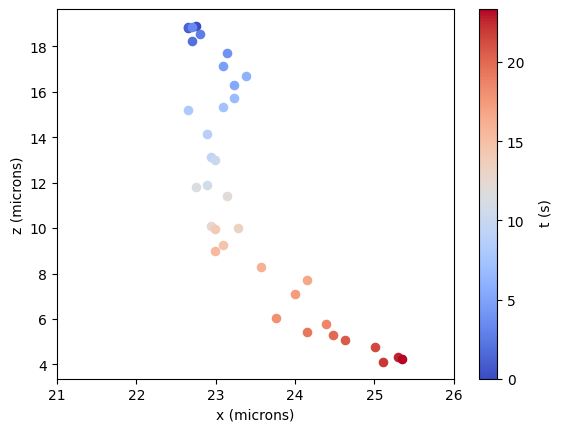

In [132]:
from matplotlib import cm
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
cm = plt.cm.get_cmap('coolwarm')
T = max(save_data.keys())
for t in save_data.keys():
    x = save_data[t][0]+(xmin*0.048)
    z = save_data[t][2]
    col = t/30
    plt.scatter([x],[z], c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
plt.xlabel('x (microns)')
plt.ylabel('z (microns)')
plt.xlim([21, 26])
c = plt.colorbar()
c.set_label('t (s)', labelpad=10, y=0.45)
plt.savefig('060922_120-mer_600_2D#0.png', dpi = 400)

### 3D

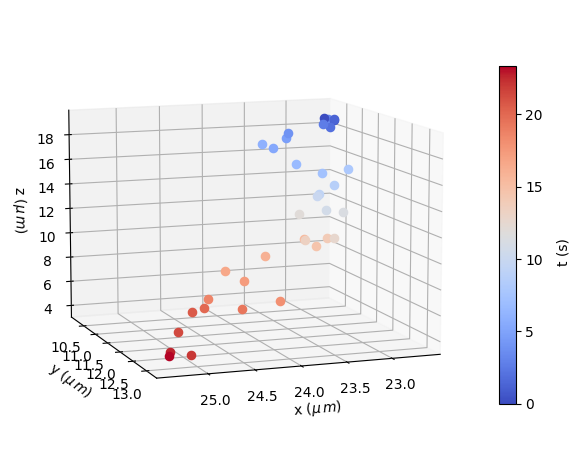

In [133]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
ax = plt.axes(projection='3d')
cm = plt.cm.get_cmap('coolwarm')
T = max(save_data.keys())
for t in save_data.keys():
    x = save_data[t][0]+(xmin*0.048)
    y = save_data[t][1]
    z = save_data[t][2]
    col = t/30
    p = ax.scatter3D([x],[y],[z], c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
c = fig.colorbar(p, orientation="vertical", pad=0.05, shrink=0.75)
c.set_label('t (s)', labelpad=10, y=0.45)
ax.set_xlabel(r'x ($\mu\,m$)')
ax.set_ylabel(r'y ($\mu\,m$)')
ax.set_zlabel('z ($\mu\,m$)')
#ax.set_xlim(36,42)
#ax.set_zlim(0,19)
ax.view_init(10, 70)
plt.tight_layout()
plt.savefig('060922_10-mer_600_3D#0.png', dpi = 400)

### plot combined plot

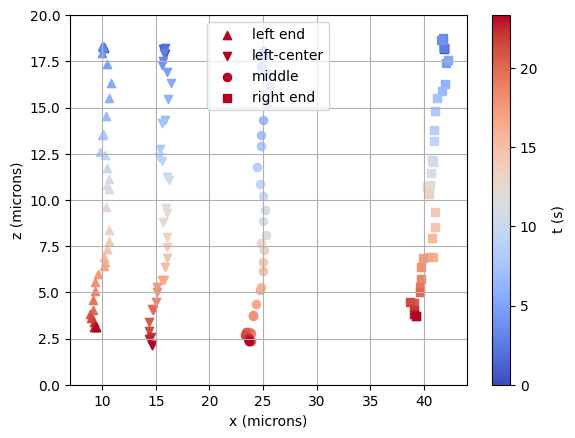

In [103]:
cm = plt.cm.get_cmap('coolwarm')
m0 = np.load('monomer060922_12-mer600_0.npy', allow_pickle = True).item() 
m2 = np.load('monomer060922_12-mer600_2.npy', allow_pickle = True).item() 
m5 = np.load('monomer060922_12-mer600_5.npy', allow_pickle = True).item() 
m11 = np.load('monomer060922_12-mer600_11.npy', allow_pickle = True).item() 

T = max(m0.keys())
for t in m0.keys():
    x0 = m0[t][0]
    x2 = m2[t][0]+(100*0.048)
    x5 = m5[t][0]+(200*0.048)
    x11 = m11[t][0]+(600*0.048)
    
    z0 = m0[t][2]
    z2 = m2[t][2]
    z5 = m5[t][2]
    z11 = m11[t][2]
    
    col = t/30
    plt.scatter([x0],[z0], marker='^', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    plt.scatter([x2],[z2], marker='v', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    plt.scatter([x5],[z5], marker='o', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    plt.scatter([x11],[z11], marker='s', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)

plt.xlabel('x (microns)')
plt.ylabel('z (microns)')

#for legend
plt.scatter([x0],[z0], marker='^', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'left end')
plt.scatter([x2],[z2], marker='v', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'left-center')
plt.scatter([x5],[z5], marker='o', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'middle')
plt.scatter([x11],[z11], marker='s', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'right end')


plt.ylim([0,20])
plt.xlim([7,44])
c = plt.colorbar()
c.set_label('t (s)', labelpad=10, y=0.45)
plt.legend(loc = 9)
plt.grid()
plt.savefig('060922_12-mer_600_2D#0#2#5#11.png', dpi = 400)

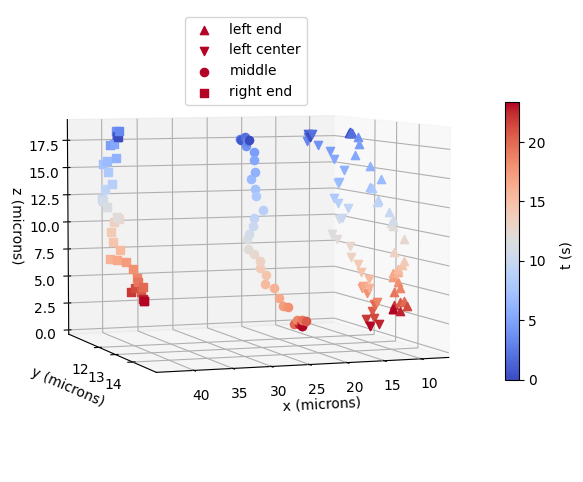

In [105]:
fig = plt.figure(figsize = (12,6))
ax = plt.axes(projection='3d')

T = max(m0.keys())
for t in m0.keys():

    x0 = m0[t][0]
    x2 = m2[t][0]+(100*0.048)
    x5 = m5[t][0]+(200*0.048)
    x11 = m11[t][0]+(600*0.048)
    
    z0 = m0[t][2]
    z2 = m2[t][2]
    z5 = m5[t][2]
    z11 = m11[t][2]
    
    y0 = m0[t][1]
    y2 = m2[t][1]
    y5 = m5[t][1]
    y11 = m11[t][1]

    col = t/30
    p = ax.scatter3D([x0],[y0],[z0], marker='^', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    ax.scatter3D([x2],[y2],[z2], marker='v', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    ax.scatter3D([x5],[y5],[z5], marker='o', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
    ax.scatter3D([x11],[y11],[z11], marker='s', c=col, vmin=0, vmax=T/30, s=35, cmap=cm)

ax.set_xlabel('x (microns)')
ax.set_ylabel('y (microns)')
ax.set_yticks([12,13,14])
ax.set_zlabel('z (microns)')

#for legend
ax.scatter3D([x0],[y0],[z0], marker='^', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'left end')
ax.scatter3D([x2],[y2],[z2], marker='v', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'left center')
ax.scatter3D([x5],[y5],[z5], marker='o', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'middle')
ax.scatter3D([x11],[y11],[z11], marker='s', c=col, vmin=0, vmax=T/30, s=35, cmap=cm, label = 'right end')


ax.set_zlim([0,19])
ax.set_xlim([7,44])
ax.view_init(5, 70)
c = fig.colorbar(p, orientation="vertical", pad=0.03, shrink=0.6)
c.set_label('t (s)', labelpad=10, y=0.45)
ax.legend(loc = 9)
plt.savefig('060922_12-mer_600_3D#0#5#11.png', dpi = 400)